In [87]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import torchvision
from tqdm.notebook import tqdm

In [2]:
!nvidia-smi

Thu Feb 24 08:01:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   23C    P8     8W / 250W |   9253MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
path = '../dataset/miniimgnet_dlassignment/tinyimgnet/tiny-imagenet-200/train/n02950826/images/'
os.listdir(path)

['n02950826_480.JPEG',
 'n02950826_442.JPEG',
 'n02950826_395.JPEG',
 'n02950826_339.JPEG',
 'n02950826_258.JPEG',
 'n02950826_17.JPEG',
 'n02950826_139.JPEG',
 'n02950826_367.JPEG',
 'n02950826_62.JPEG',
 'n02950826_334.JPEG',
 'n02950826_107.JPEG',
 'n02950826_302.JPEG',
 'n02950826_394.JPEG',
 'n02950826_102.JPEG',
 'n02950826_363.JPEG',
 'n02950826_249.JPEG',
 'n02950826_24.JPEG',
 'n02950826_8.JPEG',
 'n02950826_380.JPEG',
 'n02950826_192.JPEG',
 'n02950826_290.JPEG',
 'n02950826_300.JPEG',
 'n02950826_227.JPEG',
 'n02950826_196.JPEG',
 'n02950826_184.JPEG',
 'n02950826_477.JPEG',
 'n02950826_257.JPEG',
 'n02950826_348.JPEG',
 'n02950826_411.JPEG',
 'n02950826_94.JPEG',
 'n02950826_362.JPEG',
 'n02950826_186.JPEG',
 'n02950826_141.JPEG',
 'n02950826_338.JPEG',
 'n02950826_386.JPEG',
 'n02950826_294.JPEG',
 'n02950826_358.JPEG',
 'n02950826_167.JPEG',
 'n02950826_263.JPEG',
 'n02950826_171.JPEG',
 'n02950826_354.JPEG',
 'n02950826_125.JPEG',
 'n02950826_210.JPEG',
 'n02950826_255.J

Populating the interactive namespace from numpy and matplotlib


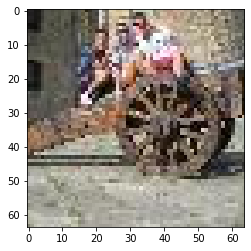

In [24]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path+'n02950826_480.JPEG')
imgplot = plt.imshow(img)
plt.show()

In [57]:
config = dict(
    saved_path="saved_models/resnet18.pt",
    lr=0.001, 
    EPOCHS = 5,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 28,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)

random.seed(config['SEED'])
np.random.seed(config['SEED'])
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])

In [58]:
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [59]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAutocontrast(0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [60]:
my_path = '../dataset/miniimgnet_dlassignment/tinyimgnet/tiny-imagenet-200/train'
images = torchvision.datasets.ImageFolder(root=my_path,transform=data_transforms['train'])
print(len(images))
train_data,valid_data = torch.utils.data.dataset.random_split(images,[5000,95000])

100000


In [62]:
images[1][0].shape

torch.Size([3, 28, 28])

In [63]:
dataset = {'images':[],'labels':[]}
for i in images:
    dataset['images'].append(i[0])
    dataset['labels'].append(i[1])

In [64]:
import pickle
a_file = open("dataset.pkl", "wb")
pickle.dump(dataset, a_file)
a_file.close()

In [83]:
a_file = open("dataset.pkl", "rb")
dataset = pickle.load(a_file)

In [84]:
len(set(dataset['labels'][:500]))

1

In [78]:
class Custom_data(Dataset):
    def __init__(self, dataset, transform = data_transforms, train=True):
        super(Custom_data,self).__init__()
        self.train_transforms = transform['train']
        self.test_transforms = transform['test']
        self.is_train = train
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:
            self.images = dataset['images']
            self.labels = np.array(dataset['labels'])
            self.index = np.array(list(range(len(self.labels))))
        
        else:
            self.images = dataset['images']
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_img = self.images[item]
        
        if self.is_train:
            anchor_label = self.labels[item]
            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item]

            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item]

            if self.train_transforms:
                anchor_img = self.train_transforms(self.to_pil(anchor_img))
                positive_img = self.train_transforms(self.to_pil(positive_img))
                negative_img = self.train_transforms(self.to_pil(negative_img))

                return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.test_transforms(self.to_pil(anchor_img))
            return anchor_img

In [79]:
train_ds = Custom_data(dataset, train=True)
train_loader = DataLoader(train_ds, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['num_workers'])

In [94]:
a = iter(train_loader)
b = next(a)
b[0].shape, b[1].shape, b[2].shape, b[3].shape

(torch.Size([32, 3, 28, 28]),
 torch.Size([32, 3, 28, 28]),
 torch.Size([32, 3, 28, 28]),
 torch.Size([32]))